In [ ]:
micromamba activate scvelo_jupyter_new
micromamba run -n scvelo_jupyter_new pip install rds2py
micromamba run -n scvelo_jupyter_new pip install twine
micromamba run -n scvelo_jupyter_new pip install git+https://github.com/furlan-lab/pyviewmaster.git
micromamba run -n scvelo_jupyter_new pip install plotly==5.24.1
micromamba run -n scvelo_jupyter_new pip install colorcet

In [58]:
# Core scverse libraries
import scanpy as sc
import anndata as ad
import scvelo as scv
import os
import glob
import pandas as pd
import numpy as np
sc.settings.set_figure_params(dpi=100, facecolor="white")
import socket
from pyviewmaster import *
import seaborn as sns
import colorcet as cc
import plotly.express as px
import matplotlib.pyplot as plt

hostname = socket.gethostname()

if hostname.startswith("gizmo"):
  ROOT_DIR1 = "/fh/fast/furlan_s/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/fh/fast/furlan_s/grp/data/ddata/BM_data"
else:
  ROOT_DIR1 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/datasets/AML/LOR_classifier/cds"
  ROOT_DIR2 = "/Users/sfurlan/Library/CloudStorage/OneDrive-SharedLibraries-FredHutchinsonCancerCenter/Furlan_Lab - General/experiments/patient_marrows/WC1/cds"


## LOAD SUMMARIZED EXPERIMENT OBJECT IN PYTHON

In [2]:
from rds2py import read_rds
ref =read_rds(ROOT_DIR1+"/240126_Combined_SE_Object.RDS")


In [3]:
coldata = get_coldata_rds_obj(ref)
coldata.set_index = coldata["rownames"]
rowdata = get_rowdata_rds_obj(ref)
rowdata.set_index = rowdata["gene_short_name"]
scounts = get_counts_rds_obj(ref)

In [4]:
rdata = ad.AnnData(scounts)
rdata.obs = coldata
rdata.var = rowdata
rdata.obs_names = coldata.index
rdata.var_names = rowdata.index
rdata.layers["counts"] = rdata.X.copy()

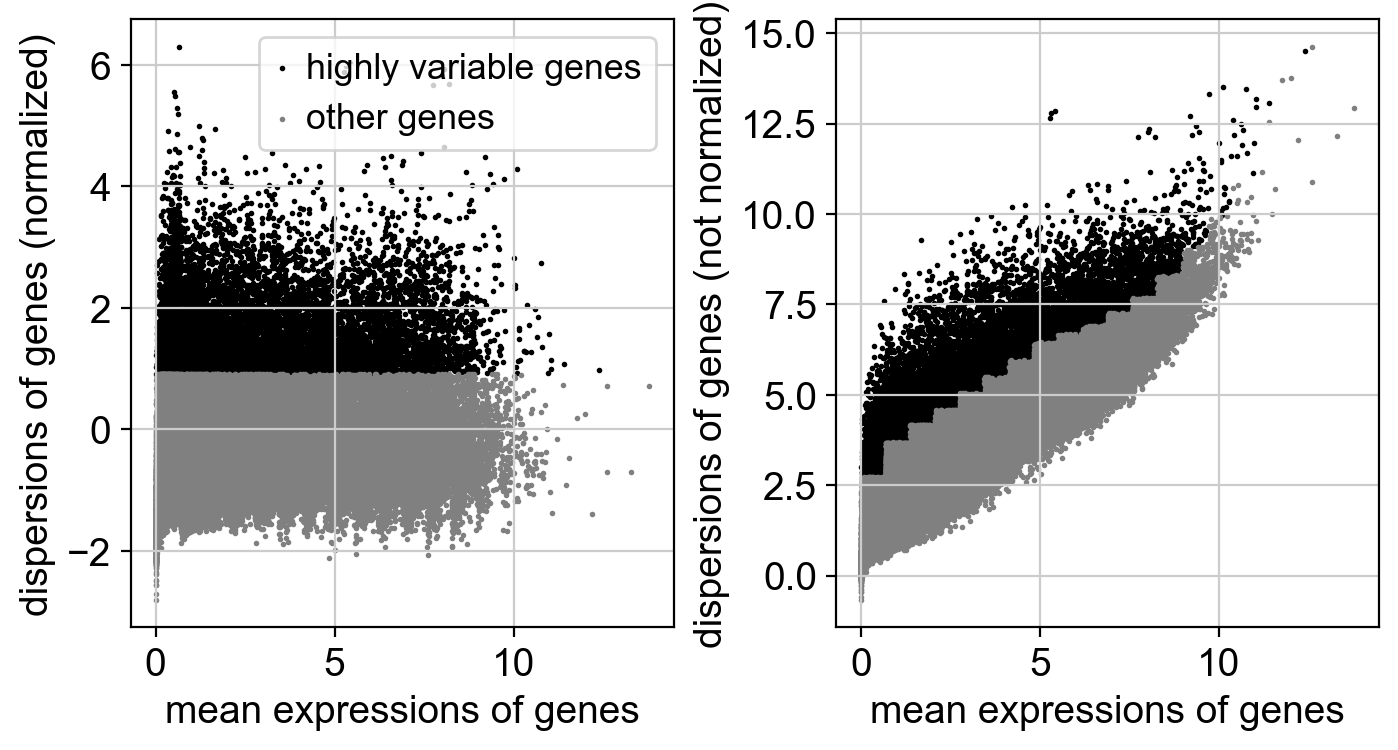

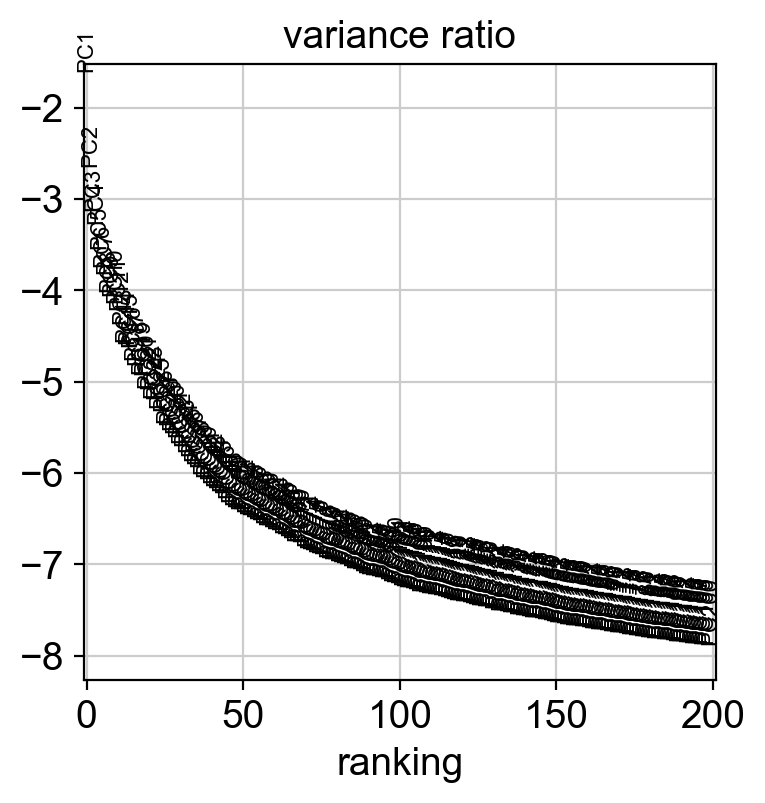

In [5]:
sc.pp.normalize_total(rdata)
sc.pp.log1p(rdata)
sc.pp.highly_variable_genes(rdata, n_top_genes=10000)
sc.pl.highly_variable_genes(rdata)
sc.tl.pca(rdata, n_comps=200)
sc.pl.pca_variance_ratio(rdata, n_pcs=200, log=True)


In [6]:
sc.pp.neighbors(rdata, n_pcs=200)


In [7]:
sc.tl.umap(rdata, min_dist=0.4, n_components=3)


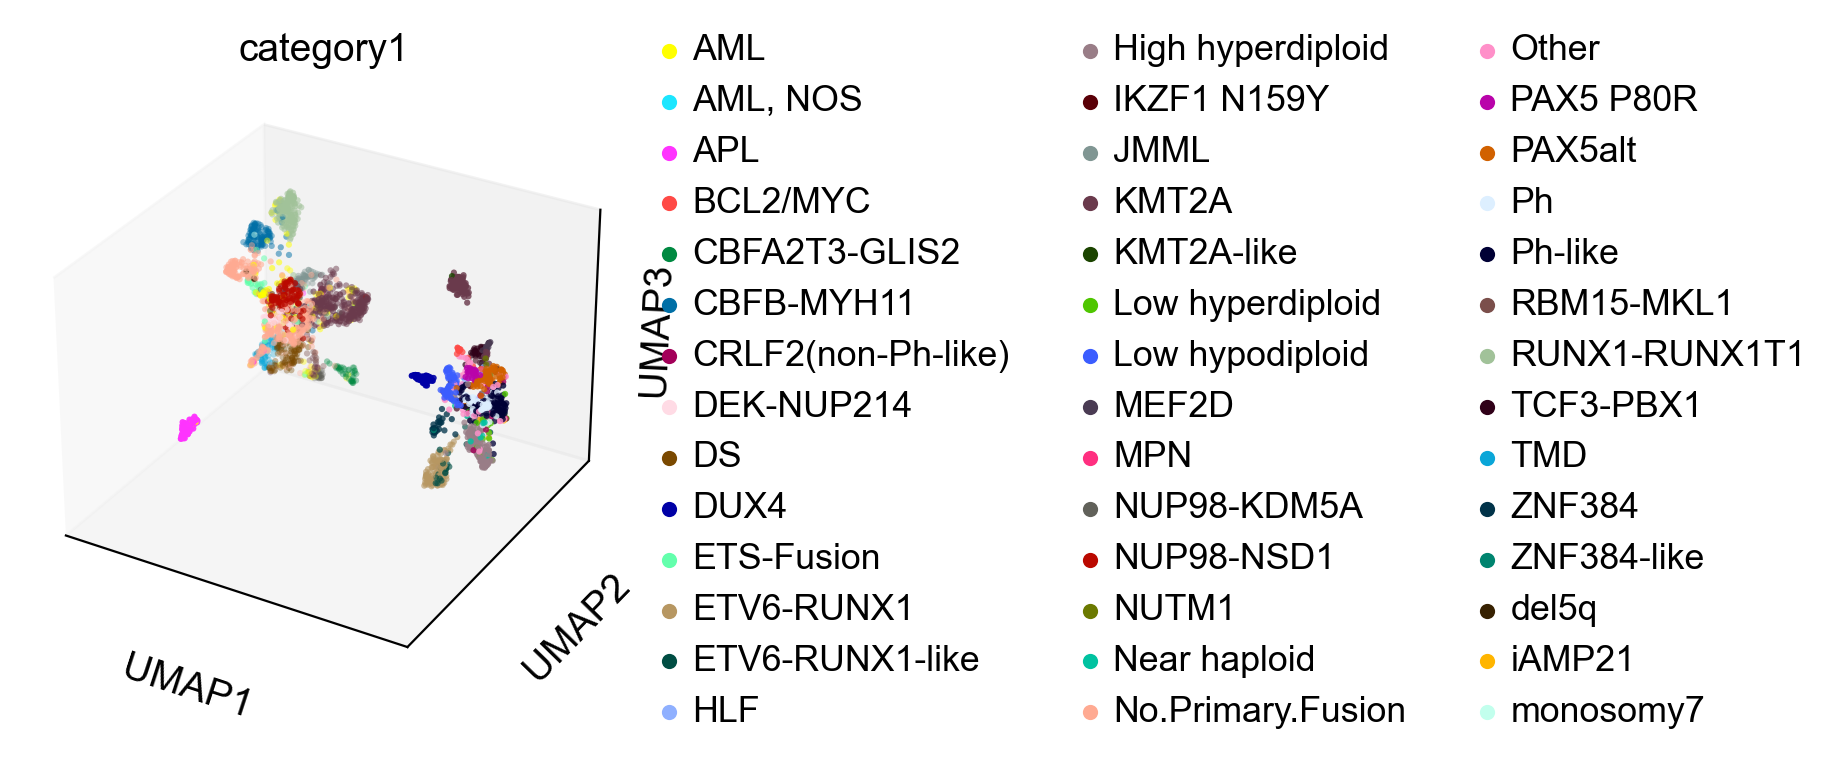

In [8]:
sc.pl.umap(rdata, color = "category1", projection = "3d")

In [9]:
palette = sns.color_palette(cc.glasbey, n_colors=50, as_cmap=True)

In [15]:
df = rdata.obsm['X_umap']
df = pd.DataFrame(df)
df.columns = ["umap1", "umap2", "umap3"]
df["category1"] = rdata.obs["category1"].values
df.index = rdata.obs.index
fig = px.scatter_3d(df, x='umap1', y='umap2', z='umap3',
              color='category1', color_discrete_sequence = palette)
fig.update_traces(marker_size = 1.5)
fig.show()


## LOAD QUERY

In [16]:
adata = sc.read_loom(ROOT_DIR2+"/WC_velocity.loom")

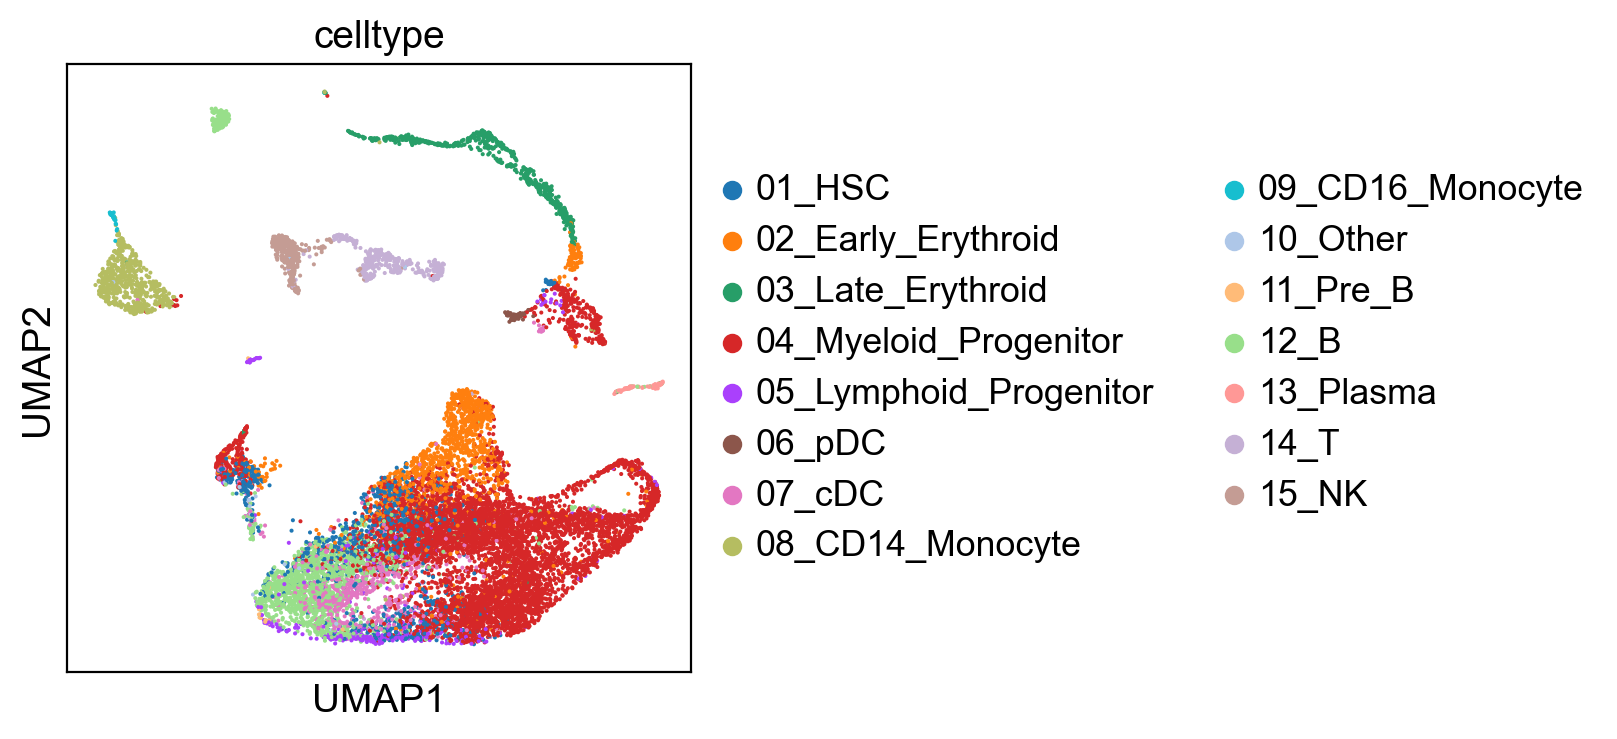

In [17]:
sc.pl.umap(adata, color = "celltype")


In [175]:
query = adata
ref = rdata
N=2
bulk_feature_row="gene_short_name"
bulk_assay_name="counts"
sc_assay_name="matrix"
dist="sc-direct"


In [176]:

# from multiprocessing import Pool, cpu_count
from scipy.stats import gaussian_kde

# def splat_bulk_reference(query=None,
#                          ref=None, N=2,
#                          bulk_feature_row="gene_short_name",
#                          bulk_assay_name="matrix",
#                          sc_assay_name="counts",
#                          dist="sc-direct"):


if dist not in ["sc-direct", "sc-model", "bulk"]:
    raise ValueError("dist must be one of 'sc-direct', 'sc-mimic', 'bulk'")

counts_query = get_counts_adata(query, layer=sc_assay_name)
sizes = sum_counts(counts_query, axis=1)
min_size = sizes.min()
max_size = sizes.max()
sd_sizes = np.std(sizes, ddof=1)
IQR_sizes = np.subtract(*np.percentile(sizes, [75, 25]))
bw = 0.9 * min(sd_sizes, IQR_sizes / 1.34) * len(sizes) ** (-1/5)

ss_cells = N * query.shape[1]
# Determine the sizes and bandwidth based on the distribution
if dist == "sc-direct":
    print("Subsampling from count distribution of query")
    final_newsizes = np.random.choice(sizes, ss_cells, replace=True)
    #newsizes = np.random.choice(sizes, ss_cells, replace=True) + np.random.normal(0, bw, N * 10)
    # trimmed_newdata = np.round(newsizes[(newsizes > np.min(sizes)) & (newsizes < np.max(sizes))])
    # final_newsizes = np.random.choice(trimmed_newdata, N, replace=False)
elif dist == "sc-model":
    print("Modelling count distribution of query")
    kde = gaussian_kde(sizes, bw_method=bw)
    x_vals = np.linspace(1, len(sizes), 1)
    final_newsizes = kde(x_vals)
else:
    counts_ref_full = get_counts_adata(ref, layer=bulk_assay_name)
    sizes = sum_counts(counts_ref_full, axis=1)
    replace_counts = True



print("Finding common features between ref and query")
genes_query = query.var_names
genes_ref = ref.var[bulk_feature_row].values
universe = np.intersect1d(genes_ref, genes_query)

if len(universe) == 0:
    raise ValueError("No common genes found between ref and query.")

print(f"Simulating {N} single cells for every bulk dataset case")

gene_to_idx = {gene: idx for idx, gene in enumerate(genes_ref)}
indices = np.array([gene_to_idx[gene] for gene in universe])

counts_ref_full = get_counts_adata(ref, layer="counts")




Subsampling from count distribution of query
Finding common features between ref and query
Simulating 2 single cells for every bulk dataset case


<Axes: ylabel='Count'>

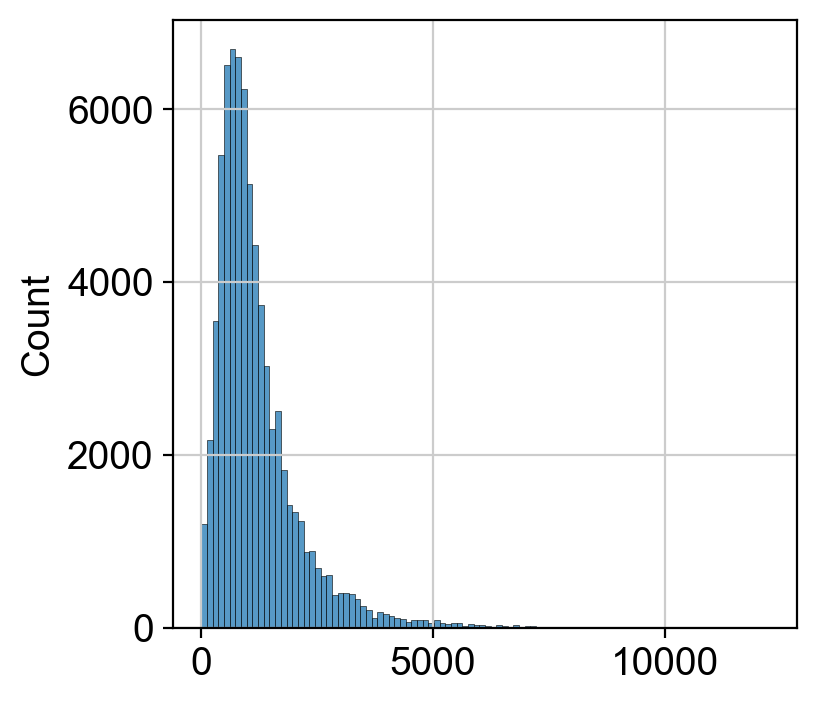

In [177]:
#sns.kdeplot(final_newsizes)
sns.histplot(final_newsizes, bins = 100)

<Axes: ylabel='Count'>

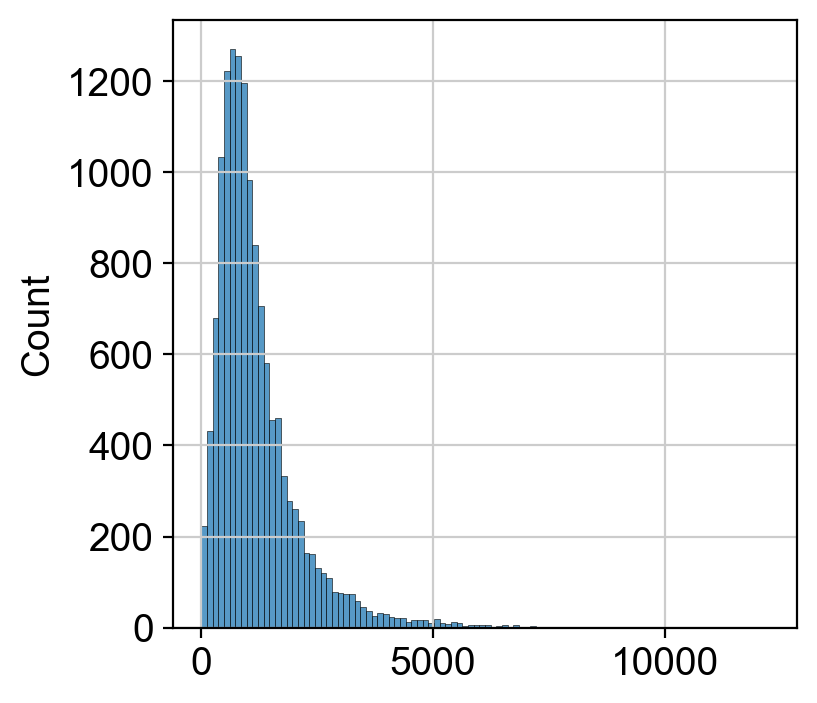

In [178]:
#sns.kdeplot(sizes)
sns.histplot(sizes, bins = 100)


In [ ]:
def inner_func(i, splat, replace_counts):
    sampled = np.random.choice(splat, int(i), replace=replace_counts)
    tab = pd.Series(sampled).value_counts()
    nf = [u for u in universe if u not in tab.index]
    zeros = pd.Series([0]*len(nf), index=nf)
    all_counts = pd.concat([tab, zeros])
    all_counts = all_counts.loc[universe]
    return all_counts

for n in range(10):
    rowdata = counts[n, :].todense().A1
    splat = np.repeat(gene_names, rowdata).tolist()
    dl = [inner_func(i, splat, replace_counts=T) for i in final_newsizes]
    result = pd.concat(dl, axis=1).fillna(0)
    return sparse.csc_matrix(result.values)


['A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1BG-AS1',
 'A1B

In [ ]:

from multiprocessing import Pool, cpu_count
def worker(n, replace_counts=F):
    newsizes = np.random.choice(sizes, N * 10, replace=True) + np.random.normal(0, bw, N * 10)
    trimmed_newdata = np.round(newsizes[(newsizes > np.min(sizes)) & (newsizes < np.max(sizes))])
    final_newsizes = np.random.choice(trimmed_newdata, N, replace=False)
    rowdata = counts.iloc[n,:]
    splat = rowdata.index.repeat(rowdata.values.astype(int))
    def inner_func(i):
        sampled = np.random.choice(splat, int(i), replace=replace_counts)
        tab = pd.Series(sampled).value_counts()
        nf = [u for u in universe if u not in tab.index]
        zeros = pd.Series([0]*len(nf), index=nf)
        all_counts = pd.concat([tab, zeros])
        all_counts = all_counts.loc[universe]
        return all_counts
    dl = [inner_func(i) for i in final_newsizes]
    result = pd.concat(dl, axis=1).fillna(0)
    return sparse.csc_matrix(result.values)



In [ ]:



def process_sample(args):
    n, counts_n = args
    rsums = counts_n
    rsums = pd.Series(rsums, index=gene_names)
    counts_gt0 = rsums[rsums > 0]
    if len(counts_gt0) == 0:
        warnings.warn(f"Sample {n} has no counts > 0.")
        return None
    splat_genes = counts_gt0.index.values
    splat_counts = counts_gt0.values.astype(int)
    splat = np.repeat(splat_genes, splat_counts)
    newsizes = np.random.choice(sizes, N, replace=True) + np.random.normal(0, bw, N)
    newsizes = newsizes[(newsizes > min_size) & (newsizes < max_size)]
    if len(newsizes) == 0:
        warnings.warn(f"No valid newsizes for sample {n}.")
        return None
    final_newsizes = np.random.choice(np.round(newsizes), N)
    dl = []
    for i in final_newsizes:
        sample_counts = np.random.choice(splat, int(i), replace=replace_counts)
        tab = pd.value_counts(sample_counts)
        all_counts = tab.reindex(gene_names, fill_value=0)
        dl.append(all_counts.values)
    return np.column_stack(dl)


In [ ]:

args_list = []
n = 1
counts_n = counts[n, :].toarray().flatten()
print(counts_n)

In [ ]:

for n in range(1):
    counts_n = counts[n, :].toarray().flatten() if scipy.sparse.issparse(counts) else counts[n, :]
    args_list.append((n, counts_n))
args_list

In [ ]:

with Pool() as pool:
    results = pool.map(process_sample, args_list)


In [ ]:

# Filter out None results
good_results = [res for res in results if res is not None]

if not good_results:
    raise ValueError("No valid data generated.")

# Concatenate data
data = np.concatenate(good_results, axis=1)

# Create metadata
metai = np.repeat(np.arange(counts.shape[1]), N)
meta = ref.obs.reset_index(drop=True)
newmeta = meta.iloc[metai, :].reset_index(drop=True)

# Create anndata object
adata_new = anndata.AnnData(X=data.T, var=pd.DataFrame(index=gene_names), obs=newmeta)


In [ ]:
sc.pl.umap(adata, color = "ground_truth", palette = cols2)

## find variable genes

In [ ]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
sc.pp.highly_variable_genes(adata,  n_top_genes=10000)
sc.pp.highly_variable_genes(adata,  n_top_genes=10000)
vg = intersection(adata.var.index[adata.var['highly_variable'].to_numpy()].tolist(), rdata.var.index[rdata.var['highly_variable'].to_numpy()].tolist())

In [ ]:
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_mlr", FUNC= "mlr", selected_genes=vg)
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_nb", FUNC= "nb", selected_genes=vg)
viewmaster(adata, rdata, "SFClassification", query_celldata_col= "vmP_nn", FUNC= "nn", selected_genes=vg)

In [ ]:
sc.pl.umap(adata, color = "vmP_mlr", palette = cols2)
sc.pl.umap(adata, color = "vmP_nb", palette = cols2)
sc.pl.umap(adata, color = "vmP_nn", palette = cols2)
sc.pl.umap(adata, color = "ground_truth", palette = cols2)